<a href="https://colab.research.google.com/github/rohinish404/learning_pytorch/blob/master/pytorch_classification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import sklearn

In [85]:
from sklearn.datasets import make_moons  
n_samples=1000
X,y = make_moons(n_samples,
                   noise = 0.03,
                   random_state=42)

In [86]:
len(X)

1000

In [87]:
X[:10]

array([[-0.00933187,  0.39098105],
       [ 0.95457387, -0.47375583],
       [ 0.9185256 , -0.42519648],
       [ 0.41276802, -0.37638459],
       [-0.84532016,  0.52879908],
       [ 0.57954249, -0.35297867],
       [ 0.29488426, -0.20923768],
       [-0.01448804,  0.4358961 ],
       [ 1.62651037, -0.28120742],
       [ 0.67159767,  0.78642227]])

In [88]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [89]:
import pandas as pd
moons = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label":y})

In [90]:
moons.head()

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0


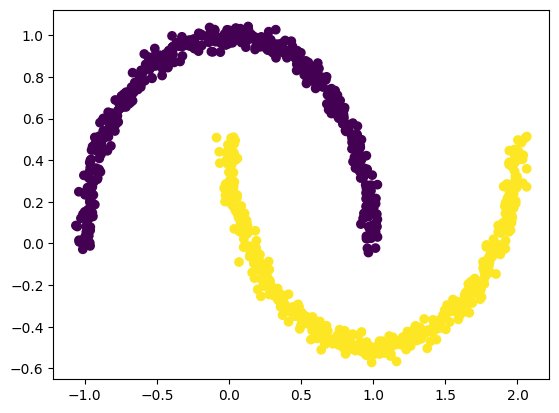

In [91]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

In [92]:
import torch
torch.__version__

'1.13.1+cu116'

In [93]:
type(X)

numpy.ndarray

In [94]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [95]:
type(X)

torch.Tensor

In [96]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [97]:

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [98]:
class ModelMoons(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=28),
            nn.ReLU(),
            nn.Linear(in_features=28, out_features=28),
            nn.ReLU(),
            nn.Linear(in_features=28, out_features=1),
        )

    def forward(self, x):
        return self.layer_stack(x)

model_1 = ModelMoons().to(device)
model_1

ModelMoons(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=1, bias=True)
  )
)

In [99]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1) 

In [100]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [101]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train.to(device))
    y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()

    loss = loss_fn(y_logits, y_train.unsqueeze(1))
    acc = acc_fn(y_pred, y_train.int())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.70517, Accuracy: 0.50% | Test loss: 0.69730, Test acc: 0.50
Epoch: 100 | Loss: 0.27713, Accuracy: 0.86% | Test loss: 0.28373, Test acc: 0.87
Epoch: 200 | Loss: 0.22568, Accuracy: 0.89% | Test loss: 0.22532, Test acc: 0.90
Epoch: 300 | Loss: 0.19877, Accuracy: 0.91% | Test loss: 0.19698, Test acc: 0.92
Epoch: 400 | Loss: 0.16295, Accuracy: 0.93% | Test loss: 0.16116, Test acc: 0.93
Epoch: 500 | Loss: 0.11920, Accuracy: 0.95% | Test loss: 0.11719, Test acc: 0.96
Epoch: 600 | Loss: 0.07602, Accuracy: 0.98% | Test loss: 0.07304, Test acc: 0.98
Epoch: 700 | Loss: 0.04585, Accuracy: 1.00% | Test loss: 0.04289, Test acc: 1.00
Epoch: 800 | Loss: 0.02914, Accuracy: 1.00% | Test loss: 0.02656, Test acc: 1.00
Epoch: 900 | Loss: 0.02001, Accuracy: 1.00% | Test loss: 0.01788, Test acc: 1.00


In [102]:
#Copied this from the pytorch notebook of the course
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
     

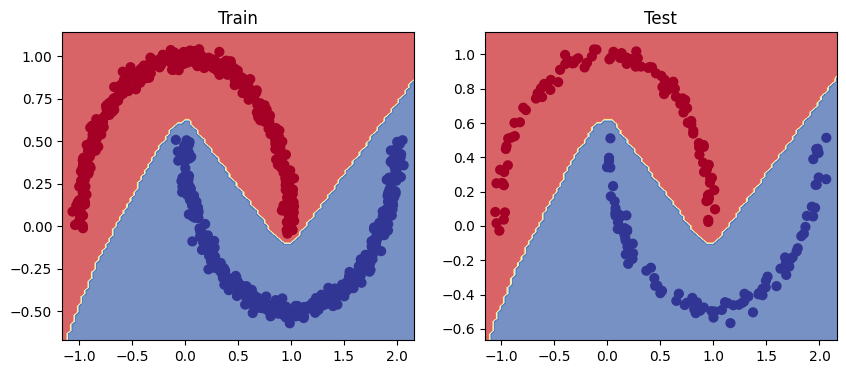

In [103]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

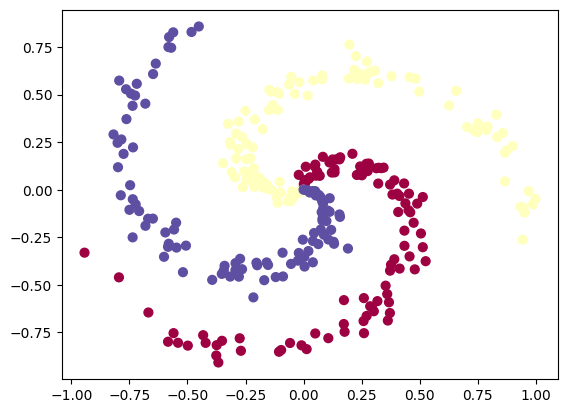

In [146]:
#copied from course notebook
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [147]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [148]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [149]:
class SpiralModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = 2,out_features = 8),
        nn.ReLU(),
        nn.Linear(in_features = 8,out_features = 8),
        nn.ReLU(),
        nn.Linear(in_features = 8,out_features = 3)
    )

  def forward(self,x):
    return self.layer_stack(x)

model_2 = SpiralModelV1()
model_2

SpiralModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [150]:
model_2.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, 

In [169]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(params=model_2.parameters(),
                           lr=0.1)

In [170]:
y_logits = model_2(X_test.to(device))
y_preds = torch.softmax(y_logits,dim=1)
print(y_preds[:5])

tensor([[6.8786e-05, 1.3438e-06, 9.9993e-01],
        [7.7603e-07, 2.5606e-07, 1.0000e+00],
        [2.6462e-09, 1.0000e+00, 8.4716e-09],
        [1.0000e+00, 5.7610e-10, 4.8542e-07],
        [7.7477e-12, 1.0135e-05, 9.9999e-01]], grad_fn=<SliceBackward0>)


In [171]:
print(torch.argmax(y_preds[0]))

tensor(2)


In [172]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


In [173]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)


  loss = loss_fn_1(y_logits,y_train)

  accuracy = accuracy_fn(y_preds,y_train)

  optimizer_1.zero_grad()
  loss.backward()
  optimizer_1.step()
  

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    loss = loss_fn(test_logits,y_test)

    test_accuracy = accuracy_fn(test_preds,y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}")


Epoch: 0 | Loss: 0.00695, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 10 | Loss: 0.00293, Accuracy: 94.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 20 | Loss: 0.00647, Accuracy: 98.75% | Test loss: 0.01297, Test acc: 100.00
Epoch: 30 | Loss: 0.00104, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 40 | Loss: 0.00066, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 50 | Loss: 0.00027, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 60 | Loss: 0.00026, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 70 | Loss: 0.00019, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 80 | Loss: 0.00019, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00
Epoch: 90 | Loss: 0.00022, Accuracy: 99.17% | Test loss: 0.01297, Test acc: 100.00


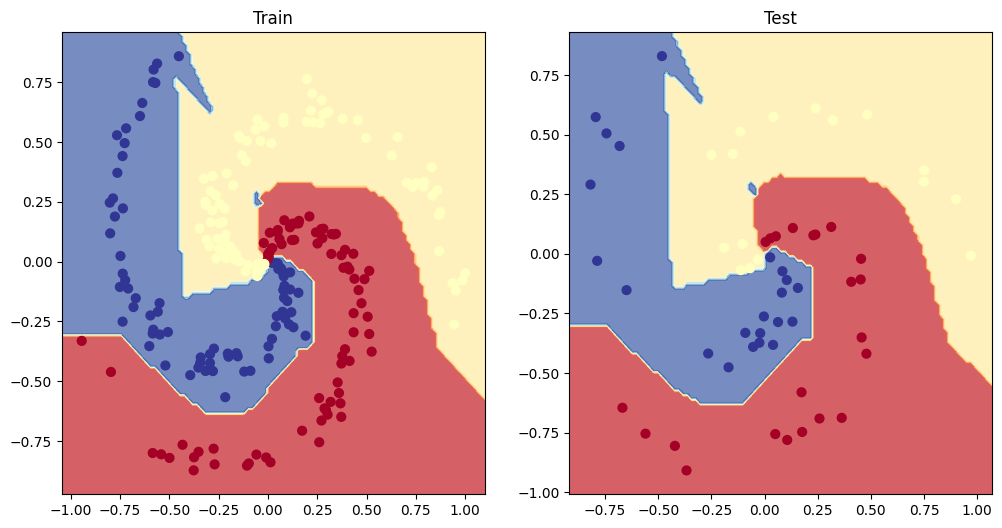

In [174]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

